In [24]:
import numpy as np 

import sys
import os

import sys
import os
#sys.path.insert(0, os.path.abspath(".."))
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt

from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 


plt.style.use('ggplot')

## Pre-whitening

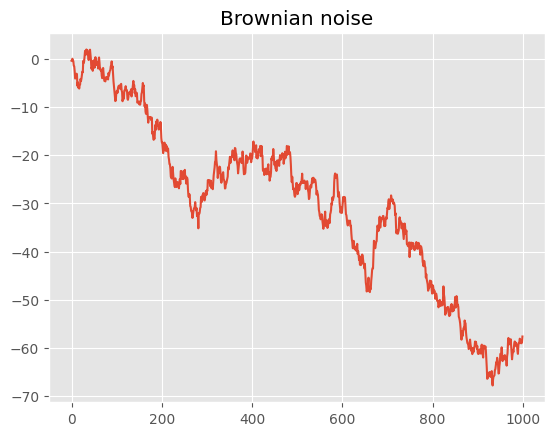

In [3]:
N = 1000

white_noise = np.random.normal(0,1,size=N)
brownian = np.cumsum(white_noise)
plt.plot(brownian)
plt.title("Brownian noise");

/tmp/ipykernel_3777287/2205875160.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs, 1/freqs**2, label="Theoretical PSD")


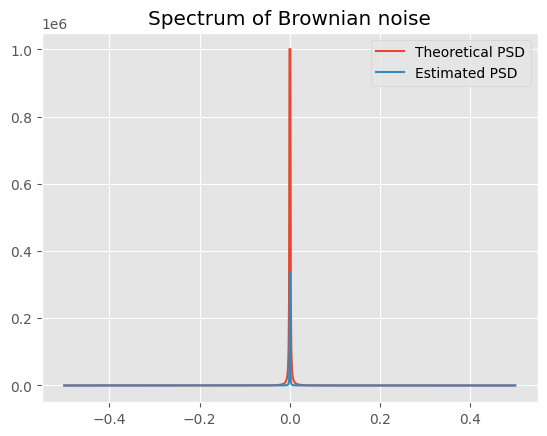

In [4]:
K = 1000
white_noise = np.random.normal(0,1,size=(K,N))
brownian_noises = np.cumsum(white_noise,axis=1)

spectrums= np.abs(np.fft.fftshift(np.fft.fft(brownian_noises, axis=1),axes=1))**2 / N 
psd = np.mean(spectrums,axis=0)
freqs = np.fft.fftshift(np.fft.fftfreq(N))
plt.title("Spectrum of Brownian noise")
plt.plot(freqs, 1/freqs**2, label="Theoretical PSD")
plt.plot(freqs,psd, label="Estimated PSD")
plt.legend();

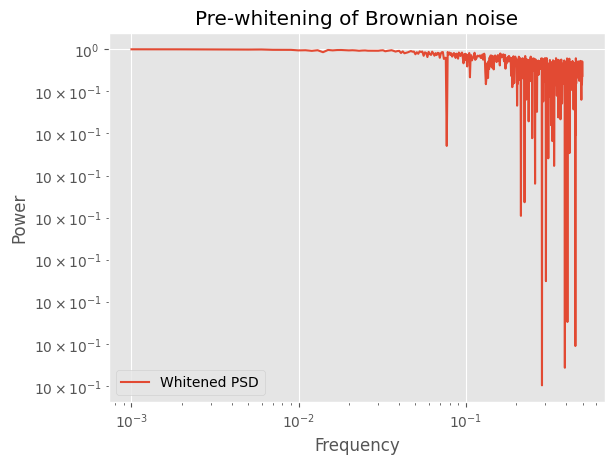

In [5]:
white = np.random.randn(N)
brownian = np.cumsum(white)

freqs = np.fft.fftfreq(N)
brownian_fft = np.fft.fft(brownian)
psd = np.abs(brownian_fft)**2


whitening_filter = 1 / (np.sqrt(psd) + 1e-12)

whitened_fft = brownian_fft * whitening_filter
whitened_psd = np.abs(whitened_fft)**2

#plt.loglog(freqs[1:N//2], psd[1:N//2],label="Original PSD")
plt.loglog(freqs[1:N//2], whitened_psd[1:N//2], label="Whitened PSD")
plt.title("Pre-whitening of Brownian noise")
plt.xlabel('Frequency')
plt.ylabel("Power")
plt.legend();

In [ ]:
n = 20
x = 0.5 + np.arange(n)*0.5 
y = x ** 2
xq = 1 + np.arange(10)

scale = (x[1] - x[0]) * n / 2 
xs = (x / scale) * np.pi / 2 
xi = (xq / scale) * np.pi / 2

delta = xi[:, None] - xs[None, :]
M = np.sin(n*delta) / (n *np.sin(delta))
M[np.isclose(delta,0)] = 1

In [2]:
def trigonometric_interpolation(x,y,z):
    """ 
    Vectorized trigonometric interpolation for equidistance points. 

    args:
        - x: equidistance sample points 
        - y: function values at sampled points
        - z: evaluation points for interpolation
    """
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * np.pi / 2 
    z_scaled = (z / scale) * np.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]

    if n % 2 == 0:
        M = np.sin(n*delta) / (n *np.sin(delta))
    else:
        M = np.sin(n*delta)/ (n*np.tan(delta))
    M[np.isclose(delta,0)] = 1

    p = M @ y 
    return p

/tmp/ipykernel_512989/3790366184.py:19: RuntimeWarning: invalid value encountered in divide
  M = np.sin(n*delta) / (n *np.sin(delta))


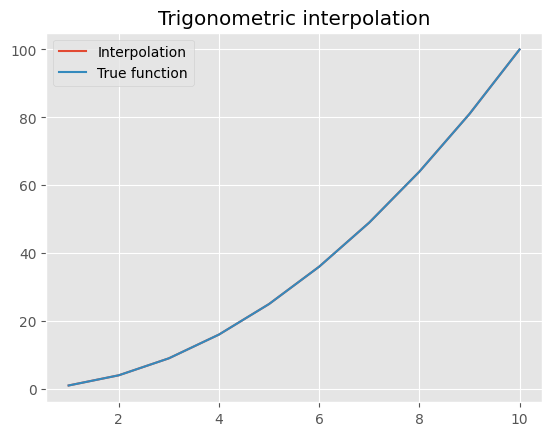

In [3]:
n = 20
x = 0.5 + np.arange(n)*0.5 
y = x ** 2
xq = 1 + np.arange(10)

p = trigonometric_interpolation(x,y, xq)
plt.plot(xq,p,label='Interpolation')
plt.plot(xq, xq ** 2, label='True function')
plt.title("Trigonometric interpolation")
plt.legend();

## Creating grid for uniform radial sampling points

The factorization of the RPSD eventually give us radial signals, that is 1-dimensional signals of both the particle spectrum and the noise spectrum. 
As we need later to interpolate it we need to have the signal at uniform sampling if we wish to use Trigonometric Interpolation.

However the sampling points generated by the behavior of the indices: $\sqrt{i^2 + j^2 + k^2}$. So it's strict than that. Instead one can generate a 3-D ACF and populate it radially to compute the 3D FFT. 
Than one can do radial average over uniform radial points and use bins to average. 

Q: Is this really necessary? What if we don't use uniform sampling. We know that points at which the 1-dimensional particle spectrum was sampled at; that is the distances generated by the indices. 
Can we use some general interpolation mechanism? Can we use any assumption on the RPSD that will allow us to better interpolate? I've seen that it's usally either Gaussian or exponential.

In [ ]:
K = 10
M = 10**2 # number of patches
L = 32
N = 2*L -1 

# Uniform sample points in [-1,1]
grid = 2/(N-1)*np.arange(N) - 1
X,Y = np.meshgrid(grid,grid)

r = (X**2 + Y** 2 ) ** 0.5 
spacing = 1 /(L-1)

# Uniform spacings for creating equdisant radial sampling points
r_bins = np.linspace(-spacing/2, spacing/2 + 1, L+1 )

# Approximated uniform sampling points by averaging bins end-points
uniform_points = (r_bins[0:-1] + r_bins[1:])/2 

bins = []
for j in range(L - 1):
    bins.append(np.where(np.logical_and(r >= r_bins[j], 
                                        r < r_bins[j + 1])))
    
bins.append(np.where(np.logical_and(r >= r_bins[L - 1], 
                                    r <= 1)))

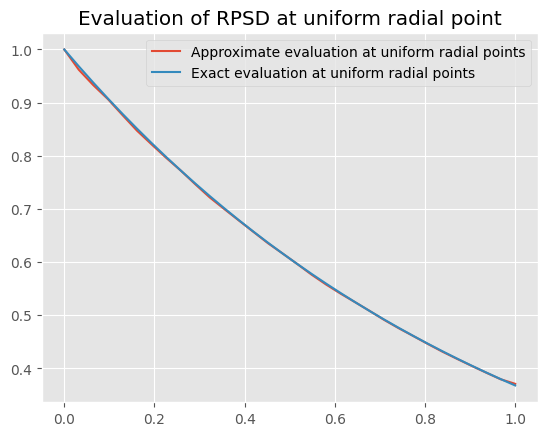

In [158]:
def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

grid = np.arange(-(L-1),L)
i,j = np.meshgrid(grid,grid)
r1 = np.sqrt(i**2 + j**2) / (L-1)
spectrum = np.exp(-r1)


s = radial_average(spectrum, bins, L)

true_spec = np.exp(-uniform_points)


plt.plot(uniform_points,s, label='Approximate evaluation at uniform radial points')
plt.plot(uniform_points,true_spec,label='Exact evaluation at uniform radial points')
plt.title("Evaluation of RPSD at uniform radial point")
plt.legend();

In [149]:
# This is a test to validate that the values are indeed bounded correctly in their magnitude
tt = [ np.logical_and(r1[bins[j]] <= r_bins[j+1], r1[bins[j]] >= r_bins[j]) for j in range(L-1)]
np.mean([np.mean(tt[i]) for i in range(L-1)])

np.float64(1.0)

Q: It can be seen that this is correct only when the magnitude is normalized by L-1. However when we are given an existing 3-d data we are not in charge of generating it in this normalized way. 
Is it okay because it only shift the function arguments? Like it only scales it.

## Experiment through full-pipeline up to extracting clean particle RPSD

In [2]:
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.spectral_estimation import estimate_isotropic_powerspectrum_tensor

K = 100
M = 10**2 # number of patches
L = 32
N = 2*L -1 

samples, S, spectrum = generate_gaussian_spectrum(L, K)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/gaussian_spectrum.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k,...] = sample[:N,:N,:N]
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/jax/_src/array.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


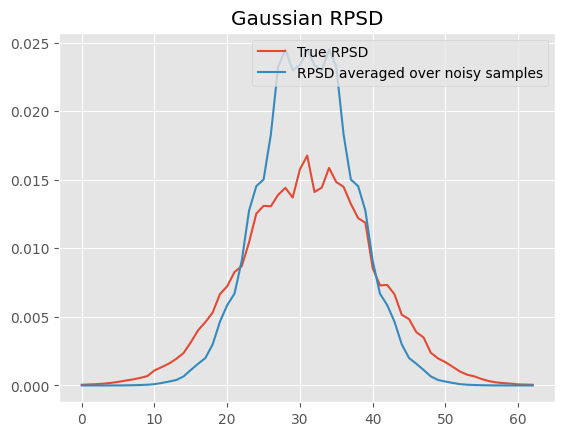

In [ ]:
plt.title("Gaussian RPSD")
plt.plot(spectrum[L,L,:], label='True RPSD')
plt.plot(S[L,L,:], label='RPSD averaged over noisy samples')
plt.legend();

In [4]:
max_d = int(np.floor(L/2))

vectorized_spectral_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor, in_axes=(0,None))
psds = vectorized_spectral_estimation(samples, max_d)

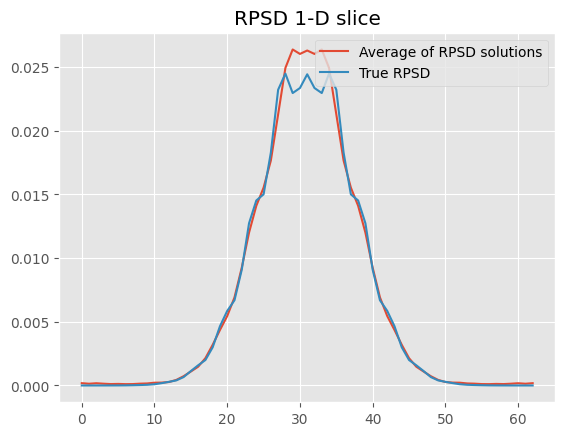

In [5]:
# TODO: Note that there constants in energy-preservations might be
# off.
avg_psd = np.mean(psds,axis=0)
avg_psd /= np.linalg.norm(avg_psd)
plt.title("RPSD 1-D slice")
plt.plot(avg_psd[L,L,:], label='Average of RPSD solutions');
plt.plot(S[L,L,:], label='True RPSD')
plt.legend();

In [6]:
# Uniform sample points in [-1,1]
grid = 2/(N-1)*np.arange(N) - 1
i,j,k= np.meshgrid(grid,grid, grid)

r = (i**2 + j** 2 + k**2) ** 0.5 
spacing = 1 /(L-1)

# Uniform spacings for creating equdisant radial sampling points
r_bins = np.linspace(-spacing/2, spacing/2 + 1, L+1 )

# Approximated uniform sampling points by averaging bins end-points
uniform_points = (r_bins[0:-1] + r_bins[1:])/2 

bins = []
for j in range(L - 1):
    bins.append(np.where(np.logical_and(r >= r_bins[j], 
                                        r < r_bins[j + 1])))
    
bins.append(np.where(np.logical_and(r >= r_bins[L - 1], 
                                    r <= 1)))

def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)

In [8]:
factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v

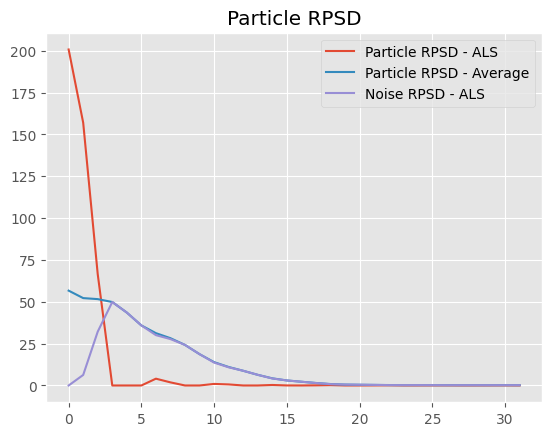

In [9]:
plt.plot(particle_psd, label='Particle RPSD - ALS')
plt.plot(np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

Interesting behavior happens here. It detects the noise RPSD to be the same as the average. 

Q: 

- Is it even correct to use this here as there's no alpha presence in the simuation? Although technically they all 1.
- Is it cause I didn't remvoe the mean from the signal?

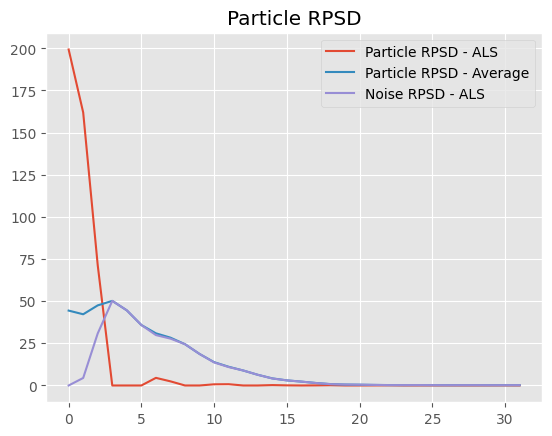

In [19]:
fixed_samples = samples - np.mean(samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fixed_samples, max_d)

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)


factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v


plt.plot(particle_psd, label='Particle RPSD - ALS')
plt.plot(np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

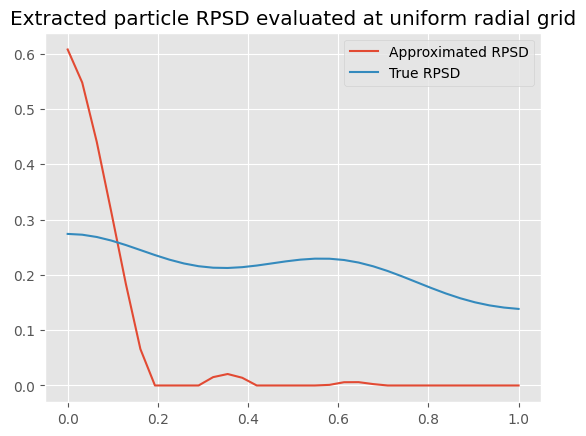

In [46]:
H = (1/np.sqrt(2*np.pi * 1 ** 2)) * np.exp(- uniform_points ** 2 / (2*1 ** 2)) * (1 + 0.1 * np.cos(10*uniform_points))

plt.plot(uniform_points,particle_psd/jnp.linalg.norm(particle_psd),
         label='Approximated RPSD')
plt.plot(uniform_points,H/jnp.linalg.norm(particle_psd),
         label='True RPSD')
plt.title("Extracted particle RPSD evaluated at uniform radial grid")
plt.legend();

## Attempt at different modeling of data

In [2]:
K = 100
N = 32
M = 2*N - 1 

sigma = 1 
w = 2*5*sigma 
w0 = w / M

grid = np.arange(-(N-1),N)
i,j,k  = np.meshgrid(grid,grid,grid) 
omega_x, omega_y, omega_z = i*w0, j*w0, k*w0
omega_r = np.sqrt(omega_x ** 2 + omega_y ** 2 + omega_z ** 2)
H = (1/np.sqrt(2*np.pi * sigma ** 2)) * np.exp(- omega_r ** 2 / (2*sigma ** 2)) * (1 + 0.1 * np.cos(10*omega_r))
C = M ** 3 / H.sum()
normalized_H = np.fft.ifftshift(np.sqrt(H * C))

window = np.bartlett(M)
samples = np.zeros((K,N,N,N))
spectrum = np.zeros((K, M,M,M))
for k in range(K):
    noise = np.random.normal(size=(M,M,M))
    sample =  normalized_H + np.abs(np.fft.fftshift(np.fft.fft(noise)))**2 / M
    samples[k,...] = sample[:N,:N,:N]
    spectrum[k,...] = cfftn(sample * window)

spectrum = np.mean(np.abs(spectrum),axis=0)
spectrum /= np.linalg.norm(spectrum) 

samples = samples.real 
S = H / np.linalg.norm(H)

/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/jax/_src/array.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


In [7]:
max_d = int(np.floor(N/2))

vectorized_spectral_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor, in_axes=(0,None))

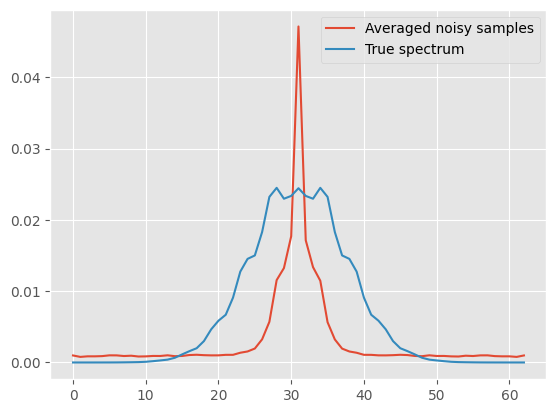

In [3]:
plt.plot(spectrum[N,N,:], label='Averaged noisy samples')
plt.plot(S[N,N,:], label='True spectrum')
plt.legend()

In [10]:
from kltpicker_3d.utils import generate_uniform_radial_sampling_points


def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

uniform_points, bins = generate_uniform_radial_sampling_points(N)

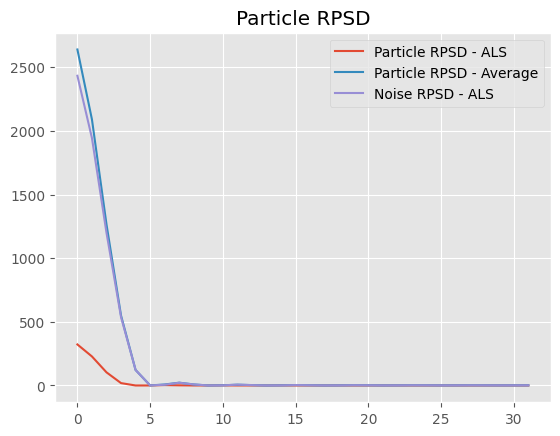

In [11]:
fixed_samples = samples - np.mean(samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fixed_samples, max_d)

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,N))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,N)


factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v


plt.plot(particle_psd, label='Particle RPSD - ALS')
plt.plot(np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

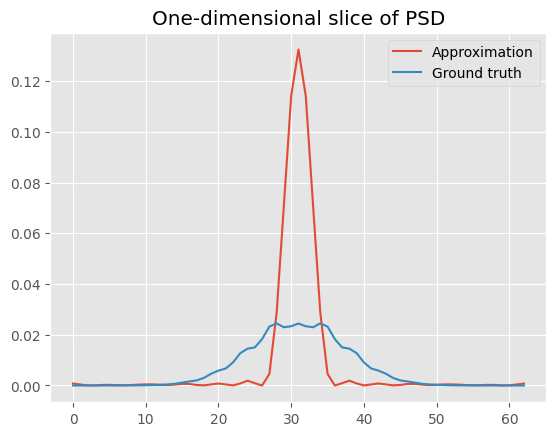

In [22]:
approx_psd = np.mean(psds,axis=0)
approx_psd /= np.linalg.norm(approx_psd)

true_psd = S / np.linalg.norm(S)
plt.plot(approx_psd[N,N,:], label="Approximation")
plt.plot(true_psd[N,N,:], label="Ground truth")
plt.legend()
plt.title("One-dimensional slice of PSD");

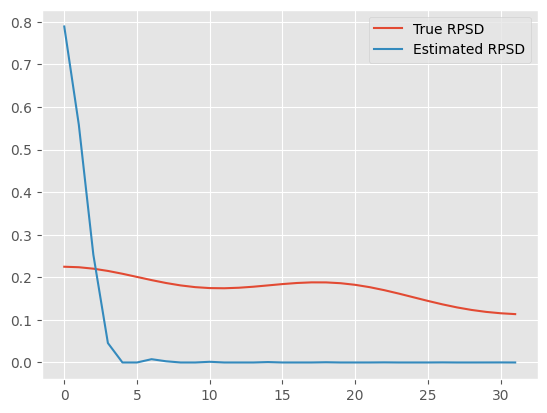

In [12]:
H = (1/np.sqrt(2*np.pi * 1 ** 2)) * np.exp(- uniform_points ** 2 / (2*1 ** 2)) * (1 + 0.1 * np.cos(10*uniform_points))
plt.plot(H/jnp.linalg.norm(H), label='True RPSD')
plt.plot(particle_psd/jnp.linalg.norm(particle_psd), 
         label='Estimated RPSD')
plt.legend();

## Pre-whitening

In [25]:
K = 100
M = 10**2 # number of patches
L = 32
N = 2*L -1 

samples, S, spectrum = generate_gaussian_spectrum(L, K)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/gaussian_spectrum.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k,...] = sample[:N,:N,:N]
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/jax/_src/array.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


In [26]:
max_d = int(np.floor(L/2))

vectorized_spectral_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor, in_axes=(0,None))
psds = vectorized_spectral_estimation(samples, max_d)

In [28]:
from kltpicker_3d.utils import generate_uniform_radial_sampling_points


def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

uniform_points, bins = generate_uniform_radial_sampling_points(L)

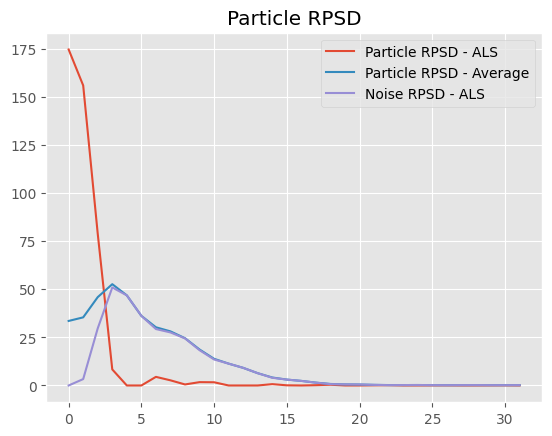

In [29]:
fixed_samples = samples - np.mean(samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fixed_samples, max_d)

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)


factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v


plt.plot(particle_psd, label='Particle RPSD - ALS')
plt.plot(np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

In [49]:
from kltpicker_3d.utils import trigonometric_interpolation

d = np.floor((L-1)/2).astype('int')
grid = np.arange(-d, d+1) * np.pi / d 
i,j,k = np.meshgrid(grid,grid,grid)
r_matrix = np.sqrt(i**2 + j**2 + k**2)
magnitudes, idx = np.unique(r_matrix, return_inverse=True)
nodes = magnitudes[magnitudes < uniform_points[-1]*np.pi]

interpolated_noise_psd = trigonometric_interpolation(uniform_points*np.pi, noise_psd, nodes)
noise_psd_mat = np.pad(interpolated_noise_psd, 
                      (0,
                       magnitudes.size - interpolated_noise_psd.size),
                      'constant',
                      constant_values=interpolated_noise_psd[-1])
noise_psd_mat.shape
noise_psd_mat = np.reshape(noise_psd_mat[idx], [grid.size, grid.size, grid.size])

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/utils.py:26: RuntimeWarning: invalid value encountered in divide
  M = np.sin(n*delta) / (n *np.sin(delta))


In [ ]:
def prewhiten_patch(patch, noise):
    filter_var = jnp.sqrt(noise)
    filter_var /= jnp.linalg.norm(filter_var)

    filter_var = (filter_var + jnp.flipud(filter_var))/2
    filter_var = (filter_var + jnp.flipur(filter_var))/2

    delta = jnp.finfo(patch.dtype)
    mask = filter_var > 100 * delta
    filter = jnp.where(mask, 1 / filter,0)